# Método 1: Features hand-crafted e classificadores do Scikit-Learn

2
Treino: (44574, 18), Teste: (19104, 18)
------------------------------------------------------------
Iniciando GridSearch (CV=5)
GridSearch Concluído em 281.74 segundos
------------------------------------------------------------
Modelos rankeados
------------------------------------------------------------
| Model                      |   mean_test_Accuracy |   mean_test_Precision |   mean_test_Recall |   mean_test_F1 |   mean_test_AUC_ROC |   mean_test_MCC |   Tempo de Fit (s) | Hyperparameters                                              |
|:---------------------------|---------------------:|----------------------:|-------------------:|---------------:|--------------------:|----------------:|-------------------:|:-------------------------------------------------------------|
| RandomForestClassifier     |               0.8325 |                0.8328 |             0.7894 |         0.8105 |              0.9054 |          0.6614 |              17.73 | {'max_depth': None, 'n_estimator

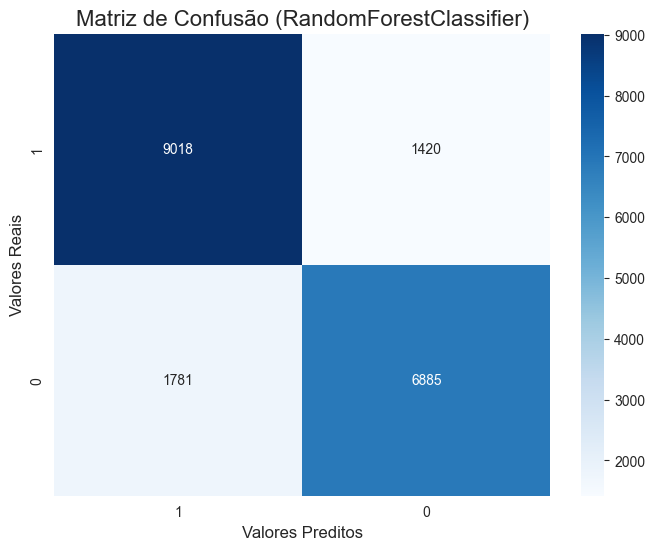

------------------------------------------------------------
Features mais usadas (Melhor Modelo):
| Feature                             | Importância   |
|:------------------------------------|:--------------|
| tamanho_medio_sentenca              | 0.101061      |
| tamanho_medio_palavra               | 0.0924963     |
| entidades_nomeadas                  | 0.0887938     |
| proporcao_stopwords                 | 0.0747763     |
| proporcao_pronomes                  | 0.0701372     |
| num_exclamacoes                     | 0.0679618     |
| proporcao_adj_adv                   | 0.0673244     |
| pontuacao_nao_terminal_por_sentenca | 0.0642978     |
| subjetividade                       | 0.0577296     |
| diversidade_lexica                  | 0.0487388     |


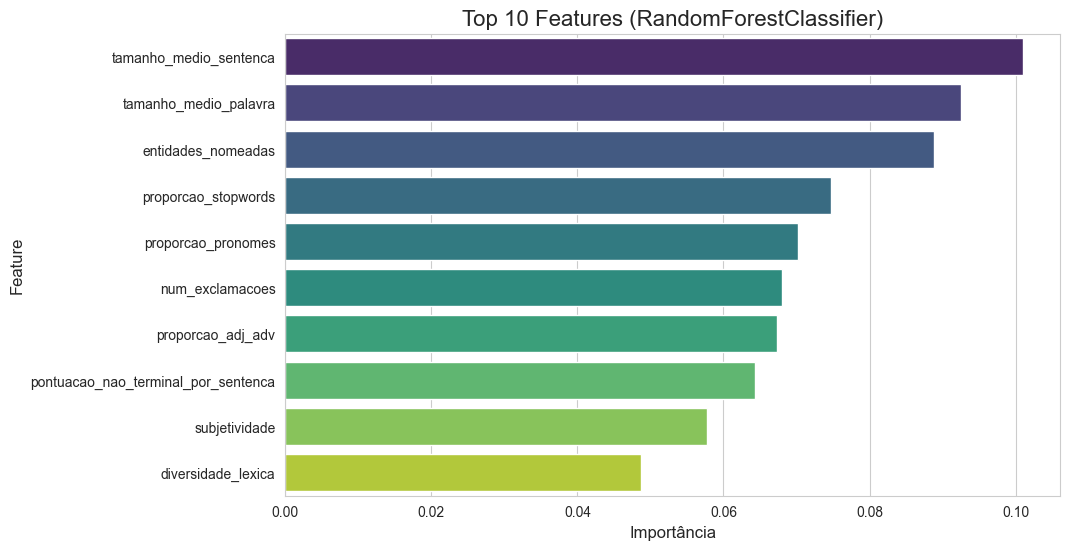

------------------------------------------------------------
Curva de Validação (overfitting)


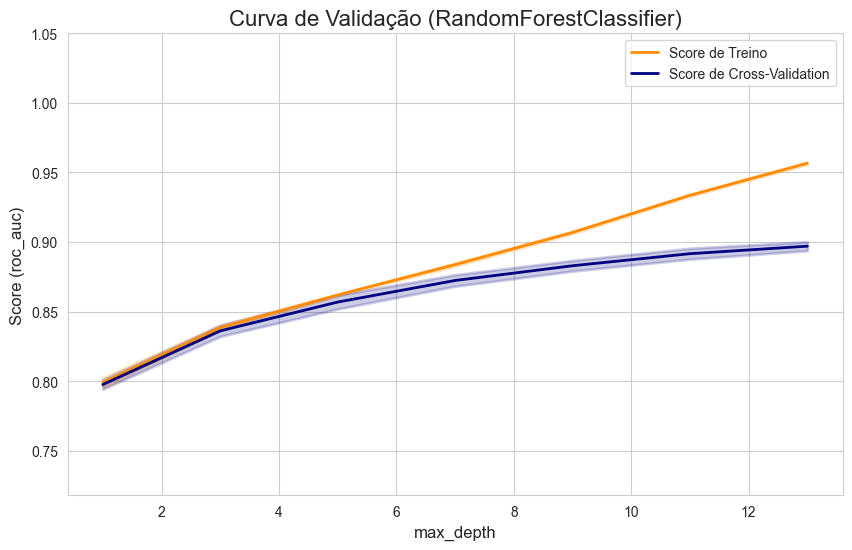

------------------------------------------------------------


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
sns.set_style("whitegrid")

try:
    data = pd.read_csv('dataset_features_sem_duplicatas_novo.csv')
except FileNotFoundError:
    print("Arquivo 'dataset_features_sem_duplicatas_novo.csv' não foi encontrado")
    exit()

if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

y = data['classe']
X_df = data.drop(columns=['classe'])
nomes_das_classes = y.unique()

print(y.nunique())
if y.nunique() > 2:
    REFIT_METRIC = 'Accuracy'
    scoring = {
        'Accuracy': 'accuracy',
        'Precision': 'precision_macro',
        'Recall': 'recall_macro',
        'F1': 'f1_macro',
        'MCC': 'matthews_corrcoef'
    }
    average_mode = 'macro'
else:
    REFIT_METRIC = 'AUC_ROC'
    scoring = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'F1': 'f1',
        'AUC_ROC': 'roc_auc',
        'MCC': 'matthews_corrcoef'
    }
    average_mode = 'binary'

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, stratify=y)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")
print("------------------------------------------------------------")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('classifier', LogisticRegression())
])

param_grid = [
    # Regressão Logística
    {
        'feature_selection': [SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), threshold='median')],
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2', 'l1'],
        'classifier__solver': ['liblinear']
    },
    # Random Forest
    {
        'feature_selection': [None, SelectFromModel(RandomForestClassifier(), threshold='median')],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [5, 10, None]
    },
    # Gradient Boosting
    {
        'feature_selection': [None],
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.1, 0.05],
        'classifier__max_depth': [3, 5]
    }
]

print(f"Iniciando GridSearch (CV=5)")
start_time = time()

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit=REFIT_METRIC, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

end_time = time()
print(f"GridSearch Concluído em {end_time - start_time:.2f} segundos")
print("------------------------------------------------------------")


def analisar_resultados_grid(grid_search, REFIT_METRIC, top_n=10):
    resultados = pd.DataFrame(grid_search.cv_results_)
    
    metricas = [m for m in scoring.keys()]
    
    colunas_teste_medias = [f'mean_test_{m}' for m in metricas]
    
    resultados = resultados.sort_values(by=f'mean_test_{REFIT_METRIC}', ascending=False)
    
    def get_model_name(params):
        return params['classifier'].__class__.__name__

    resultados['Model'] = resultados['params'].apply(get_model_name)

    def simplify_params(params):
        simple_params = {k.split('__')[-1]: v for k, v in params.items() if '__' in k}
        return str(simple_params)

    resultados['Hyperparameters'] = resultados['params'].apply(simplify_params)
    
    colunas_a_mostrar = ['Model'] + colunas_teste_medias + ['mean_fit_time', 'Hyperparameters']
    df_de_display = resultados[colunas_a_mostrar].copy()

    for col in colunas_teste_medias:
        df_de_display[col] = df_de_display[col].apply(lambda x: f"{x:.4f}")
    
    df_de_display.rename(columns={'mean_fit_time': 'Tempo de Fit (s)'}, inplace=True)
    df_de_display['Tempo de Fit (s)'] = df_de_display['Tempo de Fit (s)'].apply(lambda x: f"{x:.2f}")
    
    print(f"Modelos rankeados")
    print("------------------------------------------------------------")
    print(df_de_display.head(top_n).to_markdown(index=False))

analisar_resultados_grid(grid_search, REFIT_METRIC, top_n=10)

best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
classifier_name = best_estimator.named_steps['classifier'].__class__.__name__

print("------------------------------------------------------------")
print(f"Detalhes do Melhor Modelo (teste) - {classifier_name}")
print(f"Melhores Parâmetros (CV): {best_params}")
print("------------------------------------------------------------")

y_pred = best_estimator.predict(X_test)
y_proba = None

if y.nunique() == 2:
    try:
        y_proba = best_estimator.predict_proba(X_test)[:, 1]
    except AttributeError:
        pass

print("------------------------------------------------------------")
print("\nAvaliação")

metrics_test = {}
metrics_test['Acurácia (Accuracy)'] = accuracy_score(y_test, y_pred)
metrics_test[f'Precisão (Precision, {average_mode})'] = precision_score(y_test, y_pred, average=average_mode)
metrics_test[f'Recall ({average_mode})'] = recall_score(y_test, y_pred, average=average_mode)
metrics_test[f'Score F1 ({average_mode})'] = f1_score(y_test, y_pred, average=average_mode)
metrics_test['MCC'] = matthews_corrcoef(y_test, y_pred)

if y.nunique() == 2 and y_proba is not None:
    metrics_test['AUC-ROC'] = roc_auc_score(y_test, y_proba)

metrics_df = pd.DataFrame(metrics_test.values(), index=metrics_test.keys(), columns=['Score'])
metrics_df['Score'] = metrics_df['Score'].apply(lambda x: f"{x:.4f}")
print(metrics_df.to_markdown(numalign="left", stralign="left"))
print("------------------------------------------------------------")

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
tick_labels = nomes_das_classes if len(nomes_das_classes) < 20 else None
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.title(f'Matriz de Confusão ({classifier_name})', fontsize=16)
plt.ylabel('Valores Reais', fontsize=12)
plt.xlabel('Valores Preditos', fontsize=12)
plt.show()
print("------------------------------------------------------------")

print("Features mais usadas (Melhor Modelo):")

if hasattr(best_estimator.named_steps['classifier'], 'feature_importances_') or \
   hasattr(best_estimator.named_steps['classifier'], 'coef_'):

    if best_estimator.named_steps['feature_selection'] is not None:
        selected_features_mask = best_estimator.named_steps['feature_selection'].get_support()
        current_feature_names = X_train.columns[selected_features_mask]
    else:
        current_feature_names = X_train.columns

    if hasattr(best_estimator.named_steps['classifier'], 'feature_importances_'):
        importances = best_estimator.named_steps['classifier'].feature_importances_
        title = f'Top 10 Features ({classifier_name})'
        y_label = 'Importância'
        data_df = pd.DataFrame({'Feature': current_feature_names, y_label: importances})

    elif hasattr(best_estimator.named_steps['classifier'], 'coef_'):
        coefs = best_estimator.named_steps['classifier'].coef_
        if coefs.ndim > 1:
            coefs = coefs[0]
            
        title = f'Top 10 Coeficientes (Importância Absoluta) ({classifier_name})'
        y_label = 'Coeficiente (Valor abs.)'
        data_df = pd.DataFrame({'Feature': current_feature_names, y_label: np.abs(coefs)})

    data_df = data_df.sort_values(by=y_label, ascending=False).head(10)

    print(data_df.to_markdown(index=False, numalign="left", stralign="left"))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=y_label, y='Feature', data=data_df, palette="viridis")
    plt.title(title, fontsize=16)
    plt.xlabel(y_label, fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

else:
    print(f"O modelo {classifier_name} não possui atributos de importância (`feature_importances_` ou `coef_`).")

print("------------------------------------------------------------")


print("Curva de Validação (overfitting)")

param_name = None
param_range_plot = None
scoring_vc = 'roc_auc' if y.nunique() == 2 else 'accuracy'

if classifier_name == 'RandomForestClassifier' or classifier_name == 'DecisionTreeClassifier':
    param_name = 'classifier__max_depth'
    param_range_plot = np.arange(1, 15, 2)
elif classifier_name == 'LogisticRegression' or classifier_name == 'SVC':
    param_name = 'classifier__C'
    param_range_plot = np.logspace(-3, 2, 6)
elif classifier_name == 'GradientBoostingClassifier':
    param_name = 'classifier__n_estimators'
    param_range_plot = np.arange(50, 300, 50)

if param_name and param_range_plot is not None:
    temp_pipeline = Pipeline([
        ('scaler', best_estimator.named_steps['scaler']),
        ('feature_selection', best_estimator.named_steps['feature_selection']),
        ('classifier', best_estimator.named_steps['classifier'].__class__())
    ])

    train_scores, valid_scores = validation_curve(
        temp_pipeline,
        X_train, y_train,
        param_name=param_name,
        param_range=param_range_plot,
        cv=5,
        scoring=scoring_vc,
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Curva de Validação ({classifier_name})", fontsize=16)
    plt.xlabel(param_name.split('__')[-1], fontsize=12)
    plt.ylabel(f"Score ({scoring_vc})", fontsize=12)
    plt.ylim(min(min(train_scores_mean), min(valid_scores_mean)) * 0.9, 1.05)

    lw = 2
    plt.plot(param_range_plot, train_scores_mean, label="Score de Treino",
             color="darkorange", lw=lw)
    plt.fill_between(param_range_plot, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range_plot, valid_scores_mean, label="Score de Cross-Validation",
             color="navy", lw=lw)
    plt.fill_between(param_range_plot, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.grid(True)
    
    if param_name == 'classifier__C':
        plt.xscale('log')
        plt.xticks(param_range_plot, [f'{x:.3f}' for x in param_range_plot])
    
    plt.show()
else:
    print(f"Erro ao gerar a Curva de Validação p/ {classifier_name}.")

print("------------------------------------------------------------")